This notebook compares two recommendation strategies using K-Means on TF-IDF features:

    a. Random-in-Cluster: Randomly select products from the same cluster as the query.

    b. Centroid-Based: Recommend products closest to the cluster centroid.

We evaluate both methods using average TF-IDF distance between the query and recommended items.

In [18]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) # adjust relative import as necessary
sys.path.append(PROJECT_ROOT)
from utils.data_processing import get_filtered_review_data, get_metadata

Load

In [19]:
metadata_df = get_metadata('Video_Games')
print(metadata_df.columns)
print(metadata_df.shape)

Loading metadata from data/Video_Games_metadata.pkl
Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'store', 'categories', 'details',
       'parent_asin'],
      dtype='object')
(137269, 11)


Prepare 

In [20]:
# Make sure title/description are strings
metadata_df['title'] = metadata_df['title'].astype(str)
metadata_df['description'] = metadata_df['description'].astype(str)

# Combine them into one text column
metadata_df['combined_text'] = metadata_df['title'] + ' ' + metadata_df['description']

# drop any rows with completely empty text
metadata_df = metadata_df[metadata_df['combined_text'].str.strip().str.len() > 0]
metadata_df.reset_index(drop=True, inplace=True)

TF-IDF

In [21]:
vectorizer = TfidfVectorizer(
    stop_words='english',   # Remove English stop words
    max_features=10,      
)
X_tfidf = vectorizer.fit_transform(metadata_df['combined_text'])
print("TF-IDF matrix shape:", X_tfidf.shape)
print("Metadeta df shape : ", metadata_df.shape)    

TF-IDF matrix shape: (137266, 10)
Metadeta df shape :  (137266, 12)


Kmeans

In [22]:
k = 12 
kmeans = KMeans(n_clusters=k, random_state=42)
product_clusters = kmeans.fit_predict(X_tfidf)

# Attach cluster labels to metadata
metadata_df['cluster_id'] = product_clusters

Define our approaches

In [23]:
from sklearn.metrics import pairwise_distances

def recommend_by_cluster(product_index, df, top_n=5):
    cluster_label = df.loc[product_index, 'cluster_id']
    same_cluster_indices = df.index[df['cluster_id'] == cluster_label].tolist()
    # Exclude the product itself
    same_cluster_indices = [i for i in same_cluster_indices if i != product_index]
    # Random sample
    import random
    if len(same_cluster_indices) > 0:
        rec_indices = random.sample(same_cluster_indices, 
                                    k=min(top_n, len(same_cluster_indices)))
        return df.loc[rec_indices]
    else:
        return df.iloc[0:0]  # Return empty if no cluster mates

def recommend_closest_in_cluster(product_index, df, X, model, top_n=5):
    cluster_id = df.loc[product_index, 'cluster_id']
    same_cluster_mask = (df['cluster_id'] == cluster_id)
    same_cluster_indices = df.index[same_cluster_mask]

    centroid_vector = model.cluster_centers_[cluster_id].reshape(1, -1)
    cluster_X = X[same_cluster_indices]
    distances = pairwise_distances(cluster_X, centroid_vector, metric='euclidean').flatten()
    
    cluster_df = pd.DataFrame({'index': same_cluster_indices, 'distance': distances})
    cluster_df = cluster_df[cluster_df['index'] != product_index].sort_values('distance')
    top_recs = cluster_df.head(top_n)['index']
    return df.loc[top_recs]

def average_tfidf_distance(query_idx, rec_indices, X_matrix):
    if len(rec_indices) == 0:
        return np.nan  # or 0, if no recs
    query_vec = X_matrix[query_idx]
    rec_vecs = X_matrix[rec_indices]
    distances = pairwise_distances(query_vec, rec_vecs, metric='euclidean').flatten()
    return distances.mean()


In [24]:
import random

def compare_recommenders(
    X_tfidf,         
    metadata_df,      
    kmeans_model,     # Trained KMeans model (k=12)
    num_queries=100,  # How many random queries 
    top_n=5           # Number of recommendations per approach
):
    #store in list of dicts, then convert to df
    results = []
    n_items = len(metadata_df)
    
    for i in range(num_queries):
        query_idx = random.randint(0, n_items - 1)  #random product index
        # Approach A: random in same cluster
        random_recs = recommend_by_cluster(query_idx, metadata_df, top_n=top_n)
        random_dist_avg = average_tfidf_distance(query_idx, random_recs.index, X_tfidf)
        
        # Approach B: centroid-based
        centroid_recs = recommend_closest_in_cluster(
            query_idx, metadata_df, X_tfidf, kmeans_model, top_n=top_n
        )
        centroid_dist_avg = average_tfidf_distance(query_idx, centroid_recs.index, X_tfidf)
        
        # Store results
        results.append({
            'query_idx': query_idx,
            'approach': 'random',
            'avg_distance': random_dist_avg
        })
        results.append({
            'query_idx': query_idx,
            'approach': 'centroid',
            'avg_distance': centroid_dist_avg
        })
    
    return pd.DataFrame(results)


Testing with 100 queries

In [25]:
results_df = compare_recommenders(
    X_tfidf=X_tfidf,
    metadata_df=metadata_df,
    kmeans_model=kmeans,
    num_queries=100,
    top_n=5
)
print(results_df.head())

   query_idx  approach  avg_distance
0      87047    random      0.307712
1      87047  centroid      0.172003
2      58269    random      0.744404
3      58269  centroid      0.720474
4      97223    random      0.429052


Analyze

In [26]:
mean_values = results_df.groupby('approach')['avg_distance'].mean()
print(mean_values)

approach
centroid    0.313500
random      0.413702
Name: avg_distance, dtype: float64


<Figure size 640x480 with 0 Axes>

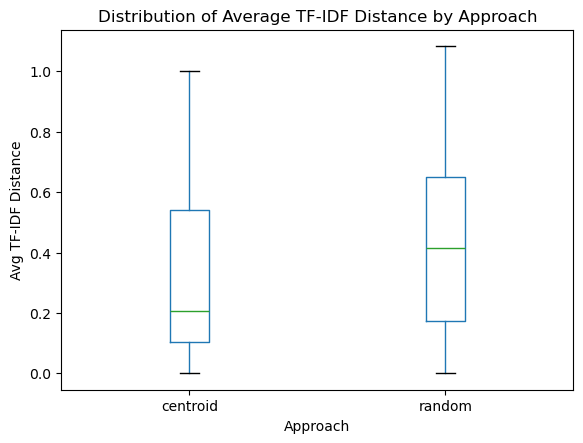

In [27]:
import matplotlib.pyplot as plt

plt.figure()
results_df.boxplot(column='avg_distance', by='approach', grid=False)
plt.title("Distribution of Average TF-IDF Distance by Approach")
plt.suptitle("")  
plt.xlabel("Approach")
plt.ylabel("Avg TF-IDF Distance")
plt.show()

Testing with 1000 queries

In [28]:
results_df = compare_recommenders(
    X_tfidf=X_tfidf,
    metadata_df=metadata_df,
    kmeans_model=kmeans,
    num_queries=1000,
    top_n=5
)
print(results_df.head())

   query_idx  approach  avg_distance
0       2280    random      0.325127
1       2280  centroid      0.205272
2      66949    random      0.439317
3      66949  centroid      0.274244
4      68071    random      0.688305


Analyze

In [29]:
mean_values = results_df.groupby('approach')['avg_distance'].mean()
print(mean_values)

approach
centroid    0.283753
random      0.391435
Name: avg_distance, dtype: float64


<Figure size 640x480 with 0 Axes>

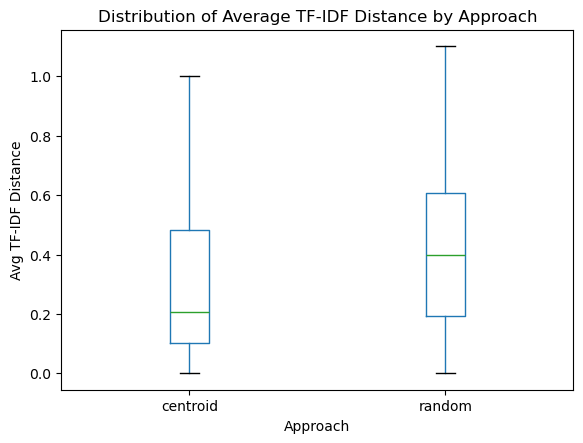

In [30]:
import matplotlib.pyplot as plt

plt.figure()
results_df.boxplot(column='avg_distance', by='approach', grid=False)
plt.title("Distribution of Average TF-IDF Distance by Approach")
plt.suptitle("")  
plt.xlabel("Approach")
plt.ylabel("Avg TF-IDF Distance")
plt.show()

Testing with 27500 queries (~20%)

In [21]:
results_df = compare_recommenders(
    X_tfidf=X_tfidf,
    metadata_df=metadata_df,
    kmeans_model=kmeans,
    num_queries=27500,
    top_n=5
)
print(results_df.head())

   query_idx  approach  avg_distance
0     124256    random      1.000000
1     124256  centroid      0.000000
2      49514    random      1.384805
3      49514  centroid      1.290215
4      30407    random      1.405531


Analyze

approach
centroid    1.161590
random      1.345337
Name: avg_distance, dtype: float64


<Figure size 640x480 with 0 Axes>

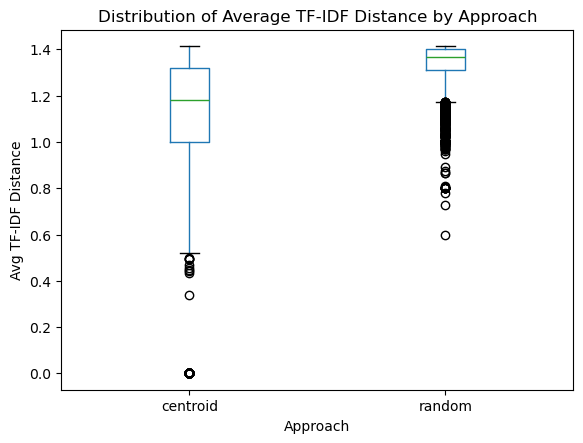

In [22]:
mean_values = results_df.groupby('approach')['avg_distance'].mean()
print(mean_values)

plt.figure()
results_df.boxplot(column='avg_distance', by='approach', grid=False)
plt.title("Distribution of Average TF-IDF Distance by Approach")
plt.suptitle("")  
plt.xlabel("Approach")
plt.ylabel("Avg TF-IDF Distance")
plt.show()

 Plots show consistent means as queries scale which is desired

Visualizing query and approach outcomes

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_tfidf.toarray())

# Attach PCA coordinates to your metadata DataFrame
metadata_df['pca_x'] = X_2d[:, 0]
metadata_df['pca_y'] = X_2d[:, 1]


In [32]:
import matplotlib.pyplot as plt

def plot_query_and_recs(metadata_df, query_idx, random_recs, centroid_recs, title=""):
    """
    Plots all items in gray, query in red, random recs in green, centroid recs in blue.
    Assumes metadata_df has columns ['pca_x', 'pca_y'] for 2D coordinates.
    """
    plt.figure(figsize=(8, 6))

    # 1) Plot all items faintly
    plt.scatter(metadata_df['pca_x'], metadata_df['pca_y'], 
                c='gray', alpha=0.3, label='All Items')

    # 2) Plot query
    qx, qy = metadata_df.loc[query_idx, ['pca_x', 'pca_y']]
    plt.scatter(qx, qy, color='red', marker='x', s=100, label='Query')

    # 3) Plot random recs
    if not random_recs.empty:
        plt.scatter(random_recs['pca_x'], random_recs['pca_y'], 
                    color='green', marker='^', s=80, label='Random Recs')

    # 4) Plot centroid recs
    if not centroid_recs.empty:
        plt.scatter(centroid_recs['pca_x'], centroid_recs['pca_y'], 
                    color='blue', marker='s', s=80, label='Centroid Recs')

    # 5) Labels and show
    plt.title(title if title else f"Query idx={query_idx}")
    plt.legend()
    plt.show()

📌 Query Index: 56416
📖 Query Title: Donop RED 2 Pack Classic Wired Long Handle Gaming D Pad Joystick Thumbstick Controller for Nintendo 64 N64 Game Console (Red

🔹 Random-in-Cluster Recommendations:
  • GeekShare Sweet Sakura Theme Thumb Grip Caps Soft Silicone Joystick Cover, 4PICS (PS4/PS5/NS Pro)
  • 2PCS Luminous Glow Fruit Thumb Stick Grip Cap Joystick Cover For Switch NS Lite Joy-Con Controller Nintend Joycon Thumbstick Case Replacement (Strawberry Orange)
  • Deal4GO Left Right Metal Lock Buckle Latches Set Replacement for Switch Joy Con Controller Metal Latch Black
  • Nintendo Switch Controller Cover Skin Set for Console Dock Joy Con Vinyl Decal Sticker Protector by BR
  • Retro Fighters BattlerGC Wireless Controller - Gamecube, Game Boy Player, Switch & PC Compatible (Blue/Purple)

🔷 Centroid-Based Recommendations:
  • HORI Nintendo Switch Pokken Tournament DX Pro Pad Wired Controller Officially Licensed by Nintendo and Pokemon
  • BelugaDesign Moon Switch Pro Controller Skin

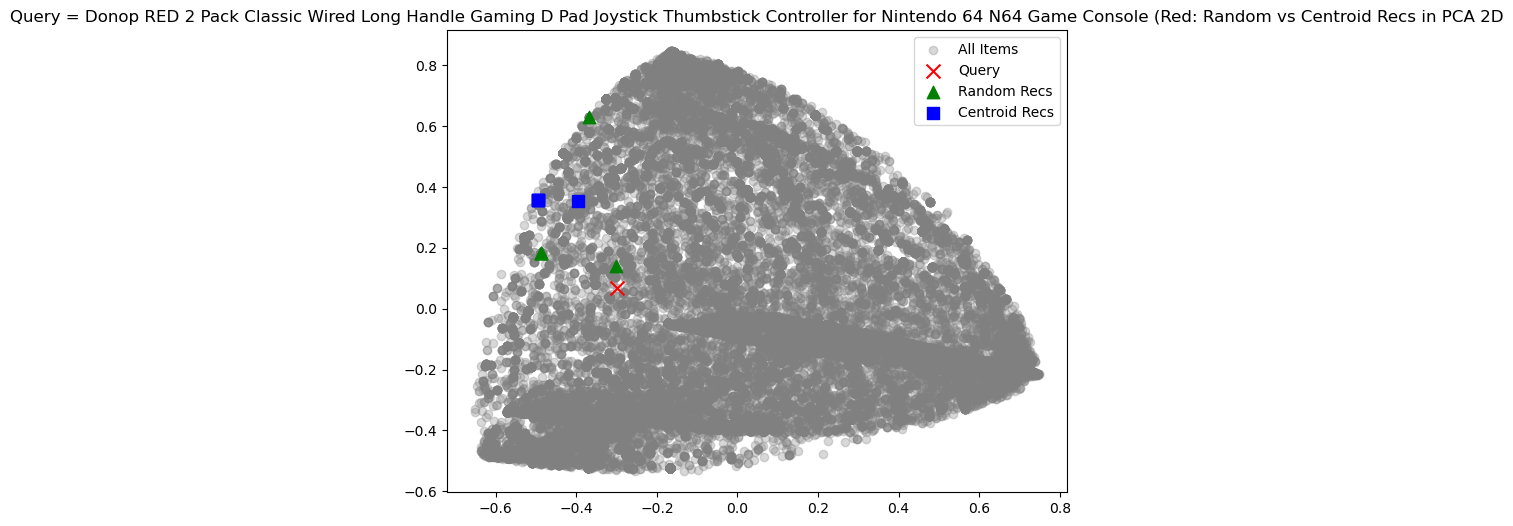

📌 Query Index: 79770
📖 Query Title: TXEsign Slim Handy Storage Portable 3ds Games Carrying Case Bag for Nintendo Switch, New3DS, New3DSLL, 3DS, 3DSLL (Black)

🔹 Random-in-Cluster Recommendations:
  • Star Wars Universal Character System Case - Boba Fett (Nintendo 2DS/3DS/3DS XL/DS/DSi XL)
  • Rover amiibo - Nintendo Wii U
  • Nintendo The Spiderwick Chronicles ( DS)
  • Nintendo DSiXL Screen Kit
  • Frozen Decorative Video Game Decal Cover Skin Protector for Nintendo 3Ds (not 3DS XL)

🔷 Centroid-Based Recommendations:
  • Nintendo 2DS Pokemon Green Limited Pack
  • BENSN 2 Pack USB Power Cord Charger Cable for Nintendo Gameboy Advance SP (GBA SP) / Nintendo Original Console, Compatible with DS NDS Game Boy Advance
  • PowerA Universal Folio Case for Nintendo DS - Animal Crossing - Nintendo DS - Nintendo 3DS
  • USonline911 Triwing Screwdriver Set Repair Tool Kit for Nintendo Wii
  • BENSN 2 Pack USB Power Cord Charger Cable for Nintendo Gameboy Advance SP (GBA SP) / Nintendo Original C

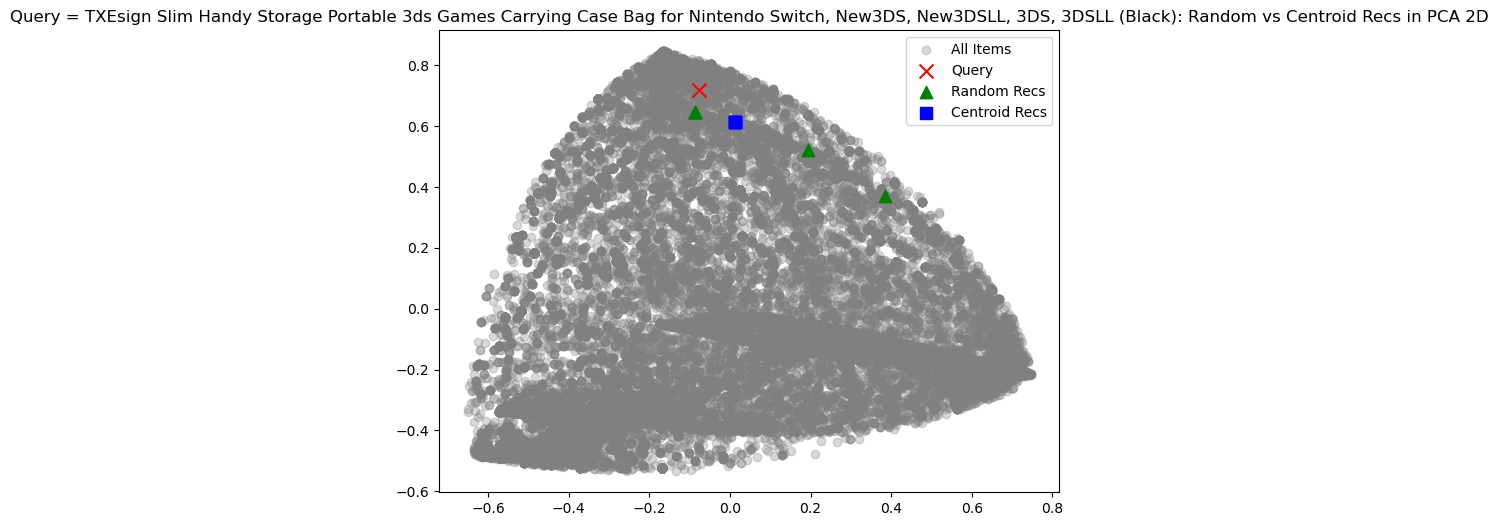

📌 Query Index: 114488
📖 Query Title: Spektrum Soft Switch: AR9100 VR6010

🔹 Random-in-Cluster Recommendations:
  • Switch TV Docking Station for Nintendo and Switch OLED, Nintendo Switch Dock Mini Portable 4K HD and USB 3.0 Port TV Dock Station Replacement(2022 Upgraded)
  • Protective Case for Nintendo Switch OLED, Soft Silicone Switch OLED Case with Game Storage - Black
  • MightySkins Skin Compatible with Nintendo Switch Lite - Floral Design | Protective, Durable, and Unique Vinyl Decal Wrap Cover | Easy to Apply, Remove, and Change Styles | Made In The USA
  • Nintendo Joy-Con (L)/(R) - The Legend of Zelda: Skyward Sword HD Edition - Switch
  • HEYSTOP Switch Lite Case

🔷 Centroid-Based Recommendations:
  • Niclogi Carry Case for Nintendo Switch, Hard Shell Protective Cover Travel Carrying Bag with 12 Game Card Slots, Inner Storage Bag for Switch Console Controller & Game Accessories, Peach Pattern
  • Niclogi Carry Case for Nintendo Switch, Hard Shell Protective Cover Travel Carry

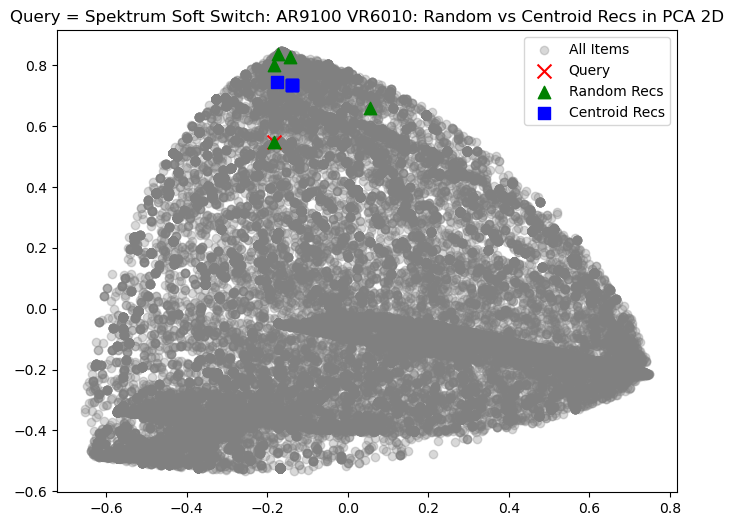

In [33]:
# Choose 3 random query indices from metadata
sample_queries = random.sample(range(len(metadata_df)), 3)

for qidx in sample_queries:
    # Get recommendations
    rand_recs = recommend_by_cluster(qidx, metadata_df, top_n=5)
    cent_recs = recommend_closest_in_cluster(qidx, metadata_df, X_tfidf, kmeans, top_n=5)
    
    # --- Print titles ---
    print("="*80)
    print(f"📌 Query Index: {qidx}")
    print(f"📖 Query Title: {metadata_df.loc[qidx, 'title']}")
    print()

    print("🔹 Random-in-Cluster Recommendations:")
    if not rand_recs.empty:
        for i, row in rand_recs.iterrows():
            print(f"  • {row['title']}")
    else:
        print("  (No recommendations found)")

    print()

    print("🔷 Centroid-Based Recommendations:")
    if not cent_recs.empty:
        for i, row in cent_recs.iterrows():
            print(f"  • {row['title']}")
    else:
        print("  (No recommendations found)")
    
    # --- Plot PCA result ---
    plot_query_and_recs(metadata_df, qidx, rand_recs, cent_recs,
                        title=f"Query = {metadata_df.loc[qidx, 'title']}: Random vs Centroid Recs in PCA 2D")
